In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')
import time


In [4]:
env = gym.make('Humanoid-v2')
env = gym.make('Humanoid-v2')

SEED = 333

env.seed(SEED);
np.random.seed(SEED);
random.seed(SEED)
torch.manual_seed(SEED);

In [16]:
discrete_action_space_dim = 9
input_dim = env.observation_space.shape[0]
hidden_dim = 765
output_dim = env.action_space.shape[0] * discrete_action_space_dim
device = torch.device('cuda')
#output_dim = train_env.action_space.shape[0]
print (input_dim, output_dim)

376 153


In [17]:
action = env.action_space.sample()

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.maxpool = nn.MaxPool1d(discrete_action_space_dim, stride=discrete_action_space_dim, return_indices=True)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc_2(x)
        x1, indices = self.maxpool(x)
        return x1, indices

In [19]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)
        
def get_actions(action_indices):
    actions = [-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4]
    ret_actions = np.zeros(env.action_space.shape[0])
    for i in range(0, len(action_indices)):
        index = action_indices[i] - i*discrete_action_space_dim
        ret_actions[i] = actions[index]
    return ret_actions
        

In [20]:
# Define the nET
q_network = MLP(input_dim, hidden_dim, output_dim).to(device)
q_network.apply(init_weights)

MLP(
  (fc_1): Linear(in_features=376, out_features=765, bias=True)
  (fc_2): Linear(in_features=765, out_features=153, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (maxpool): MaxPool1d(kernel_size=9, stride=9, padding=0, dilation=1, ceil_mode=False)
)

In [21]:
LEARNING_RATE = 7.5e-4 #0.01

optimizer = optim.Adam(q_network.parameters(), lr = LEARNING_RATE)

discount_factor = 0.8
epsilon = 0.9
decay_rate = 0.99965
# learnin_rate = 1e-6


# Hyper params
n_iters = 30
steps_per_iter = 4000
phase = 'train'
max_step = 1000

In [22]:
def update_network(q_network, state, action, reward, next_state, discount_factor, optimizer):
    q_vals, action_indices = q_network(state)
    #print ("q_vals: ", q_vals.shape, "action indices: ", action_indices.shape)
    action_preds = get_actions(action_indices.view((-1)))

    with torch.no_grad():
        q_next_vals, action_next_indices = q_network(next_state)
        targets = reward + q_next_vals.sum() * discount_factor

    loss = F.smooth_l1_loss(targets.detach(), q_vals)
    
    optimizer.zero_grad()
    
    loss.backward()

    nn.utils.clip_grad_norm_(q_network.parameters(), 0.5)

    optimizer.step()
    
    return loss.item()

In [23]:
def agent_run(max_steps, global_steps, epsilon, eval_mode):
    
    done = False
    episode_reward = 0
    step_count = 0

    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0).to(device)

    for steps in range(max_steps):
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_pred, action_indices = q_network(state)
            action = get_actions(action_indices.view((-1)))

        next_state, reward, done, _ = env.step(action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        episode_reward += reward

        loss = update_network(q_network, state, action, reward, next_state, discount_factor, optimizer)
        state = next_state
        step_count+=1
        
        if done:
            break

    return step_count, episode_reward

In [24]:
start_time = time.time()

total_num_steps = 0
train_sum_returns = 0.
train_num_episodes = 0
eval_mode = False

train_avg_ret = []
train_ep_ret = []
eval_avg_ret = []
eval_ep_ret = []
epsilon = 0.9
decay_rate = 0.995

for i in range(n_iters):
        # Perform the training phase, during which the agent learns
        if phase == 'train':
            train_step_count = 0
            while train_step_count <= steps_per_iter:
                eval_mode = False
                epsilon = max(epsilon*decay_rate, 0.1)
                
                # Run one episode
                train_step_length, train_episode_return = agent_run(max_step, i, epsilon, eval_mode)
                
                total_num_steps += train_step_length
                train_step_count += train_step_length
                train_sum_returns += train_episode_return
                train_num_episodes += 1

                train_average_return = train_sum_returns / train_num_episodes if train_num_episodes > 0 else 0.0
                
                train_avg_ret.append(train_average_return)
                train_ep_ret.append(train_episode_return)


        # Perform the evaluation phase -- no learning
        eval_sum_returns = 0.
        eval_num_episodes = 0
        eval_mode = True

        for _ in range(10):
            # Run one episode
            eval_step_length, eval_episode_return = agent_run(max_step, i, 0, eval_mode)

            eval_sum_returns += eval_episode_return
            eval_num_episodes += 1

        eval_average_return = eval_sum_returns / eval_num_episodes if eval_num_episodes > 0 else 0.0
        eval_avg_ret.append(eval_average_return)
        eval_ep_ret.append(eval_episode_return)


        if phase == 'train':
            print('---------------------------------------')
            print('Iterations:', i + 1)
            print('Steps:', total_num_steps)
            print('Episodes:', train_num_episodes)
            print('EpisodeReturn:', round(train_episode_return, 2))
            print('AverageReturn:', round(train_average_return, 2))
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')
        else:
            print('---------------------------------------')
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')
            

---------------------------------------
Iterations: 1
Steps: 4024
Episodes: 159
EpisodeReturn: 153.19
AverageReturn: 123.31
EvalEpisodes: 10
EvalEpisodeReturn: 120.93
EvalAverageReturn: 123.97
Time: 31
---------------------------------------
---------------------------------------
Iterations: 2
Steps: 8035
Episodes: 306
EpisodeReturn: 112.56
AverageReturn: 126.1
EvalEpisodes: 10
EvalEpisodeReturn: 126.46
EvalAverageReturn: 122.76
Time: 67
---------------------------------------
---------------------------------------
Iterations: 3
Steps: 12051
Episodes: 451
EpisodeReturn: 121.15
AverageReturn: 127.21
EvalEpisodes: 10
EvalEpisodeReturn: 121.02
EvalAverageReturn: 122.81
Time: 105
---------------------------------------
---------------------------------------
Iterations: 4
Steps: 16059
Episodes: 598
EpisodeReturn: 119.68
AverageReturn: 127.22
EvalEpisodes: 10
EvalEpisodeReturn: 126.94
EvalAverageReturn: 122.96
Time: 144
---------------------------------------
-----------------------------

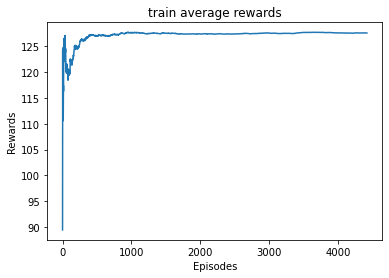

Text(0.5, 1.0, 'train episode rewards')

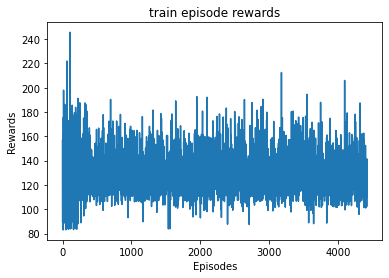

In [33]:
plt.show()
plt.plot(train_avg_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("train average rewards")

plt.show()
plt.plot(train_ep_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("train episode rewards")

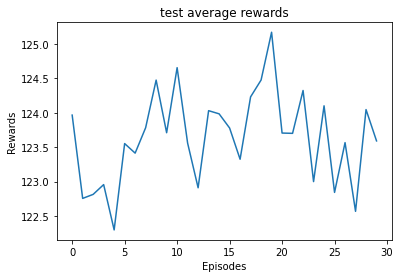

Text(0.5, 1.0, 'test episode rewards')

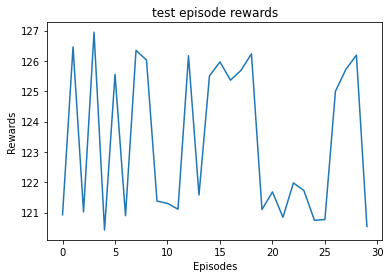

In [34]:
plt.show()
plt.plot(eval_avg_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("test average rewards")

plt.show()
plt.plot(eval_ep_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("test episode rewards")